In [83]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from SynRBL.SynMCS import FindMissingGraphs
from rdkit import Chem
#bug = load_database('../../Data/MCS/Bug.json.gz')
#bug = load_database('../../Data/MCS/Intersection_MCS_0_50_largest.json.gz')
bug = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')
original = load_database('../../Data/MCS/Original_data_Intersection_MCS_3+_matching_ensemble.json.gz')
msc_df = pd.DataFrame(bug)

              
mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)

[12:29:36] reactant 0 has no mapped atoms.
[12:29:36] product atom-mapping number 1 not found in reactants.
[12:29:36] product atom-mapping number 2 not found in reactants.
[12:29:36] reactant 0 has no mapped atoms.
[12:29:36] product atom-mapping number 1 not found in reactants.
[12:29:36] product atom-mapping number 2 not found in reactants.
[12:29:36] reactant 0 has no mapped atoms.
[12:29:36] product atom-mapping number 1 not found in reactants.
[12:29:36] product atom-mapping number 2 not found in reactants.
[12:29:36] reactant 0 has no mapped atoms.
[12:29:36] product atom-mapping number 1 not found in reactants.
[12:29:36] product atom-mapping number 2 not found in reactants.
[12:29:36] reactant 0 has no mapped atoms.
[12:29:36] product atom-mapping number 1 not found in reactants.
[12:29:36] product atom-mapping number 2 not found in reactants.
[12:29:36] reactant 0 has no mapped atoms.
[12:29:36] product atom-mapping number 1 not found in reactants.
[12:29:36] product atom-map

In [110]:
from typing import List, Dict

class GraphMissingUncertainty:
    """
    A class to handle uncertainty in graph data. It identifies uncertain elements in the graphs based on boundary conditions and fragment count.

    Attributes:
        missing_graph_list (List[Dict]): A list of graph data in dictionary format.
        threshold (int): A threshold value to determine uncertainty based on the number of fragments in a SMILES string.
    """

    def __init__(self, missing_graph_list: List[Dict], threshold: int = 2) -> None:
        """
        Initializes the GraphMissingUncertainty class with missing graph data and a threshold.

        Args:
            missing_graph_list (List[Dict]): The list of missing graph data.
            threshold (int, optional): The threshold for determining uncertainty based on fragments. Defaults to 2.
        """
        self.missing_graph_list = missing_graph_list
        self.threshold = threshold
  
    @staticmethod
    def check_boundary(data_list: List[Dict]) -> List[int]:
        """
        Identifies the indices of entries in the data list where 'boundary_atoms_products' is empty.

        Args:
            data_list (List[Dict]): A list of dictionaries, each containing a key 'boundary_atoms_products'.

        Returns:
            List[int]: A list of indices where 'boundary_atoms_products' is empty.
        """
        without_boundary_key = []

        for key, item in enumerate(data_list):
            if not item['boundary_atoms_products']:  # Checks if 'boundary_atoms_products' is empty
                without_boundary_key.append(key)

        return without_boundary_key
    
    @staticmethod
    def check_fragments(data_list: List[Dict], threshold: int = 2) -> List[int]:
        """
        Identifies the indices of entries in the data list where the number of SMILES string fragments meets or exceeds a specified threshold.

        Args:
            data_list (List[Dict]): A list of dictionaries, each containing a 'smiles' key.
            threshold (int): The minimum number of fragments in a SMILES string to be considered uncertain.

        Returns:
            List[int]: A list of indices where the number of SMILES string fragments meets or exceeds the threshold.
        """
        graph_uncertain_key = []

        for key, entry in enumerate(data_list):
            for i in entry['smiles']:
                if len(i.split('.')) >= threshold:
                    graph_uncertain_key.append(key)

        return graph_uncertain_key
    
    def fit(self) -> List[Dict]:
        """
        Processes the missing graph data to update their 'Certainty' status based on boundary and fragment checks.

        Returns:
            List[Dict]: The updated list of missing graph data with 'Certainty' status marked.
        """
        uncertain_key = []
        without_boundary_key = self.check_boundary(self.missing_graph_list)
        graph_uncertain_key = self.check_fragments(self.missing_graph_list, threshold=self.threshold)
        
        uncertain_key.extend(without_boundary_key)
        uncertain_key.extend(graph_uncertain_key)

        for key, missing_graph in enumerate(self.missing_graph_list):
            missing_graph['Certainty'] = key not in uncertain_key

        return self.missing_graph_list


In [112]:
new_graph = GraphMissingUncertainty(missing_results, threshold=2).fit()
pd.DataFrame(new_graph).describe(include='all')

smiles boundary_atoms_products nearest_neighbor_products  issue  \
count   15700                   15700                     15700  15700   
unique    239                     169                       768      1   
top       [C]            [[{'C': 0}]]              [[{'O': 1}]]          
freq     2210                    3084                      1724  15700   

       Certainty  
count      15700  
unique         2  
top         True  
freq       13478

In [114]:
pd.DataFrame(new_graph)['Certainty'].sum()

13478

In [121]:
len(new_graph)

15700

In [141]:
after_mcs_3 = load_database('../../Data/MCS/After_Merge_and_Expansion_3+.json.gz')
len(after_mcs_3)

15700

In [176]:
certain_mcs_impute = []
for key, values in enumerate(new_graph):
    if values['Certainty'] == True:
        certain_mcs_impute.append(after_mcs_3[key])
key_list = [key for key, value in enumerate(certain_mcs_impute) if value['new_reaction']]
certain_mcs_impute_fix = [certain_mcs_impute[i] for i in key_list]


In [162]:
len(certain_mcs_impute_fix)

13430

In [174]:
15700-13430

2270

In [178]:
id_certain = [item['R-id'] for item in certain_mcs_impute_fix]


In [179]:
original_uncertainty = [original[key] for key, value in enumerate(original) if value['R-id'] not in id_certain]

In [180]:
len(original_uncertainty)

2270

In [163]:
13430/15700

0.8554140127388535

In [161]:
from SynRBL.rsmi_utils import load_database, get_random_samples_by_key
valid_mcs  = get_random_samples_by_key(certain_mcs_impute_fix, num_samples_per_group=50, random_seed=42, stratify_key= 'compound_rules')
len(valid_mcs)

350

In [155]:
valid_mcs[300]

{'id': 'US20130296569A1',
 'R-id': 'R1081',
 'old_reaction': None,
 'new_reaction': None,
 'merge_rules': None,
 'compound_rules': None,
 'issue': ["Merge rule 'default single bond' failed. Could not remove any more neighboring H atoms from S."]}

In [152]:
398*0.9

358.2

1. Certainty reaction

- Missmatch Ether/Ester
- C-Br break => C-H
- New C-C formation + halogen ~ Metal
- Decarboxylation + hoffmann rearangement 200-220
- C=CBr2 => C#C 240-260


2. Uncertainty
- Ester: Solvatation + Hydrogenation => can be automatically solved
- Generation of cyclopropan => params.BondTyper = rdFMCS.BondCompare.CompareAny=> only can do with C=C and C-C; C#C is different
- Mismatch between CH3 and CH2 => addHs
- C#C can match with C=C

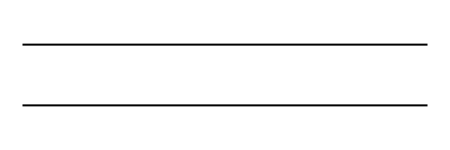

In [380]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

def preprocess_mol(mol):
    """ Convert triple bonds to double bonds for MCS matching """
    edit_mol = Chem.RWMol(mol)
    for bond in edit_mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.TRIPLE:
            bond.SetBondType(Chem.BondType.DOUBLE)
    return edit_mol.GetMol()

# Load your molecules
mol1 = Chem.MolFromSmiles('C#C')
mol2 = Chem.MolFromSmiles('C=C')

# Preprocess the molecules
preprocessed_mols = [preprocess_mol(mol) for mol in [mol1, mol2]]

# Perform the MCS search
params = rdFMCS.MCSParameters()
params.atomCompare = rdFMCS.AtomCompare.CompareElements
params.bondCompare = rdFMCS.BondCompare.CompareAny  # Now C=C will match C-C

mcs_result = rdFMCS.FindMCS(preprocessed_mols, params)
mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
mcs_mol


In [284]:
original_uncertainty[0]

{'id': 'US20100120864A1',
 'class': 7,
 'reactions': 'COC(=O)C(N)c1cccc(NC2CCCCC2)c1>>NC(CO)c1cccc(NC2CCCCC2)c1',
 'reactants': 'COC(=O)C(N)c1cccc(NC2CCCCC2)c1',
 'products': 'NC(CO)c1cccc(NC2CCCCC2)c1',
 'R-id': 'R82',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 1, 'O': 1}}

In [286]:
valid_mcs_uncertain  = get_random_samples_by_key(original_uncertainty, num_samples_per_group=5, random_seed=42, stratify_key= 'Diff_formula')
len(valid_mcs_uncertain)

86

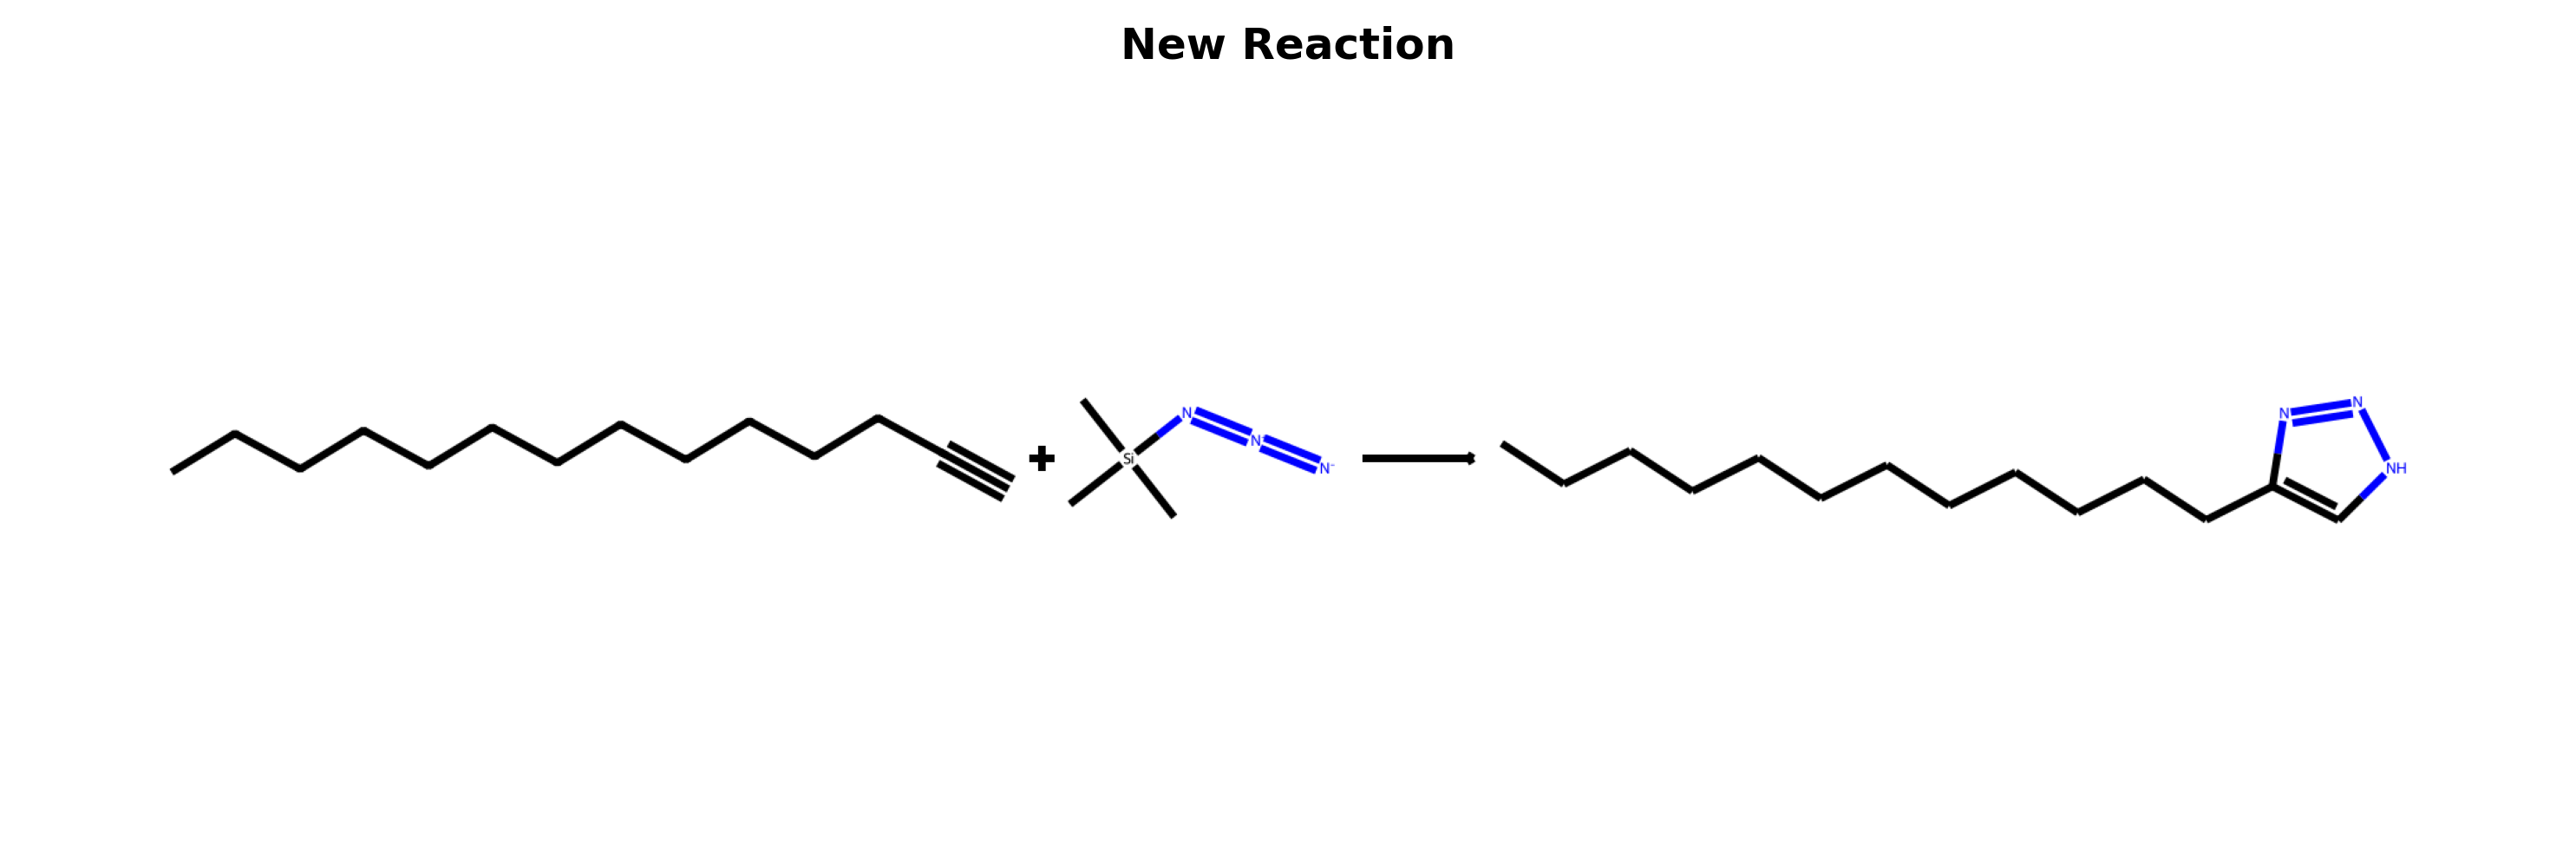

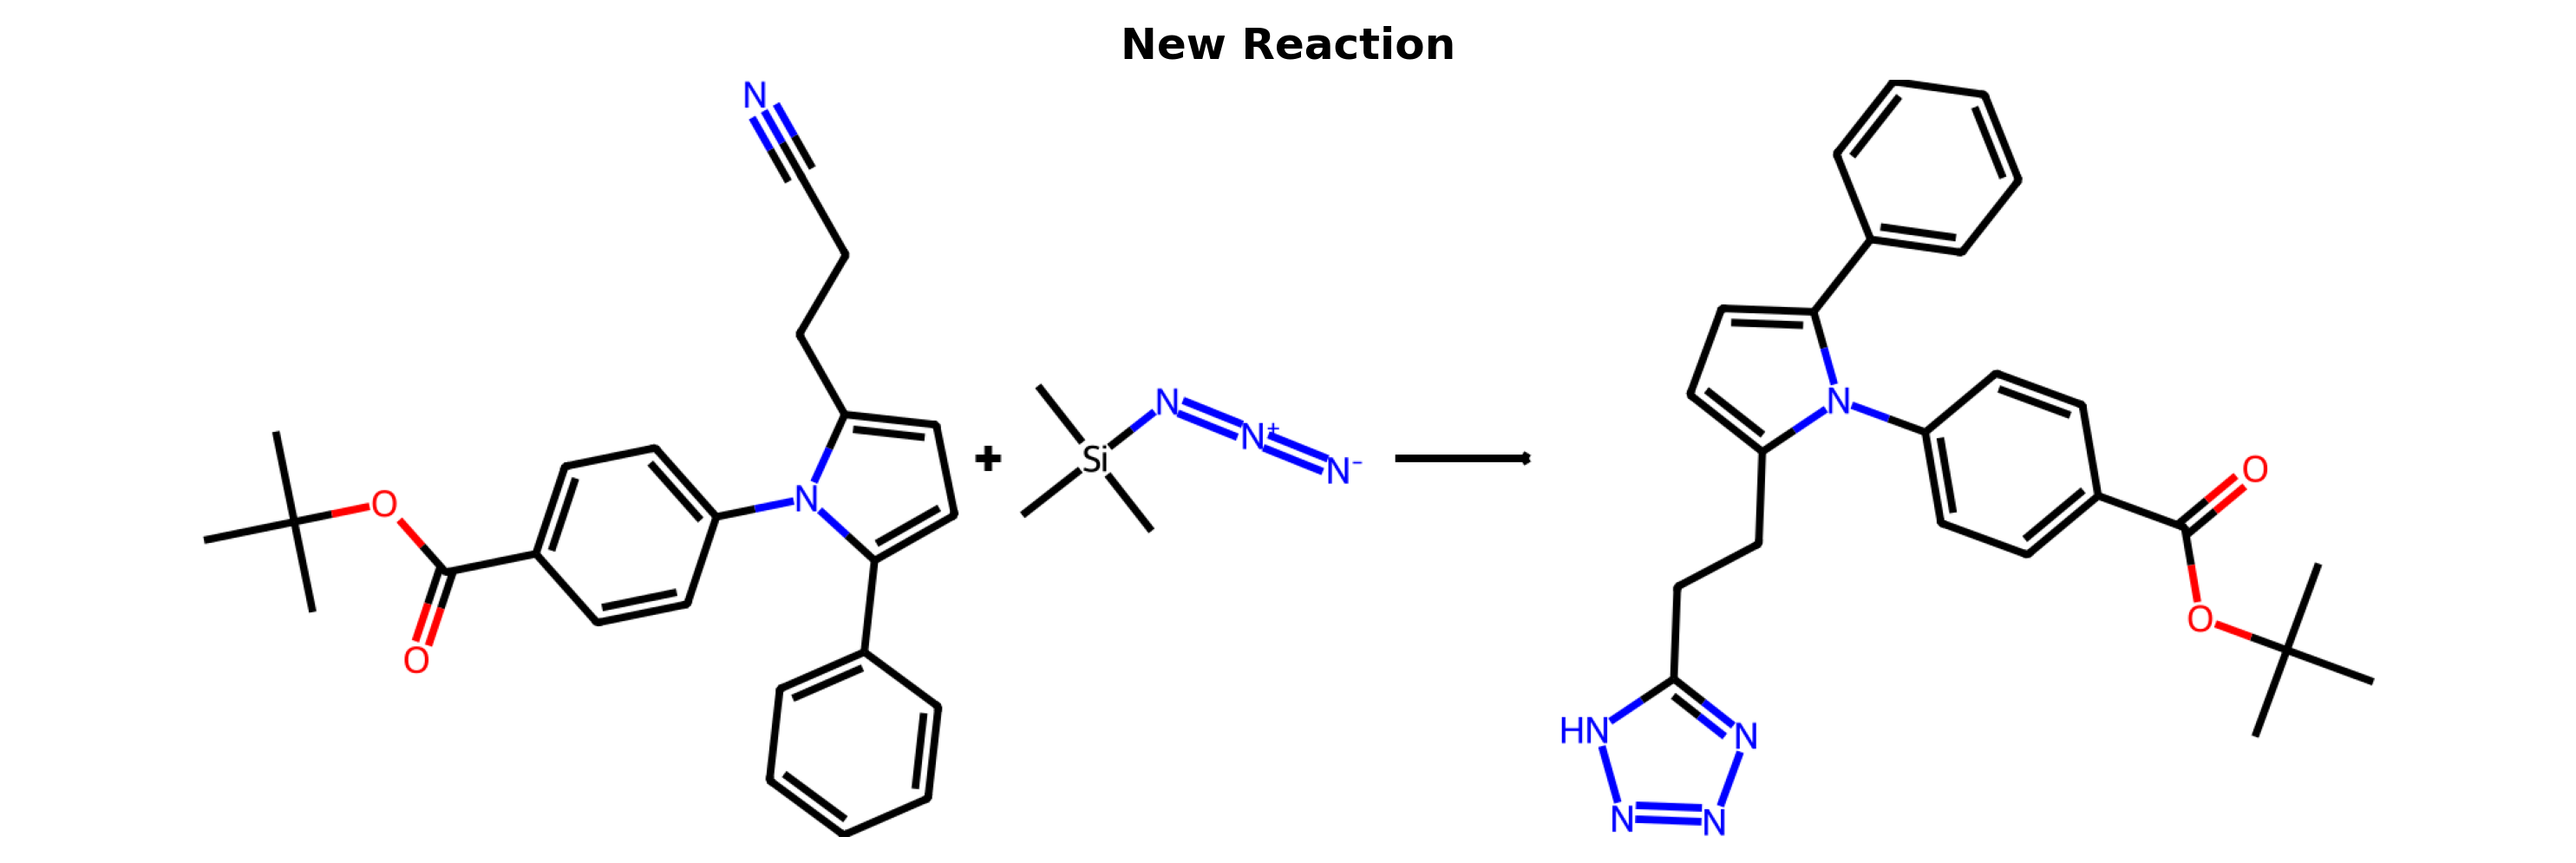

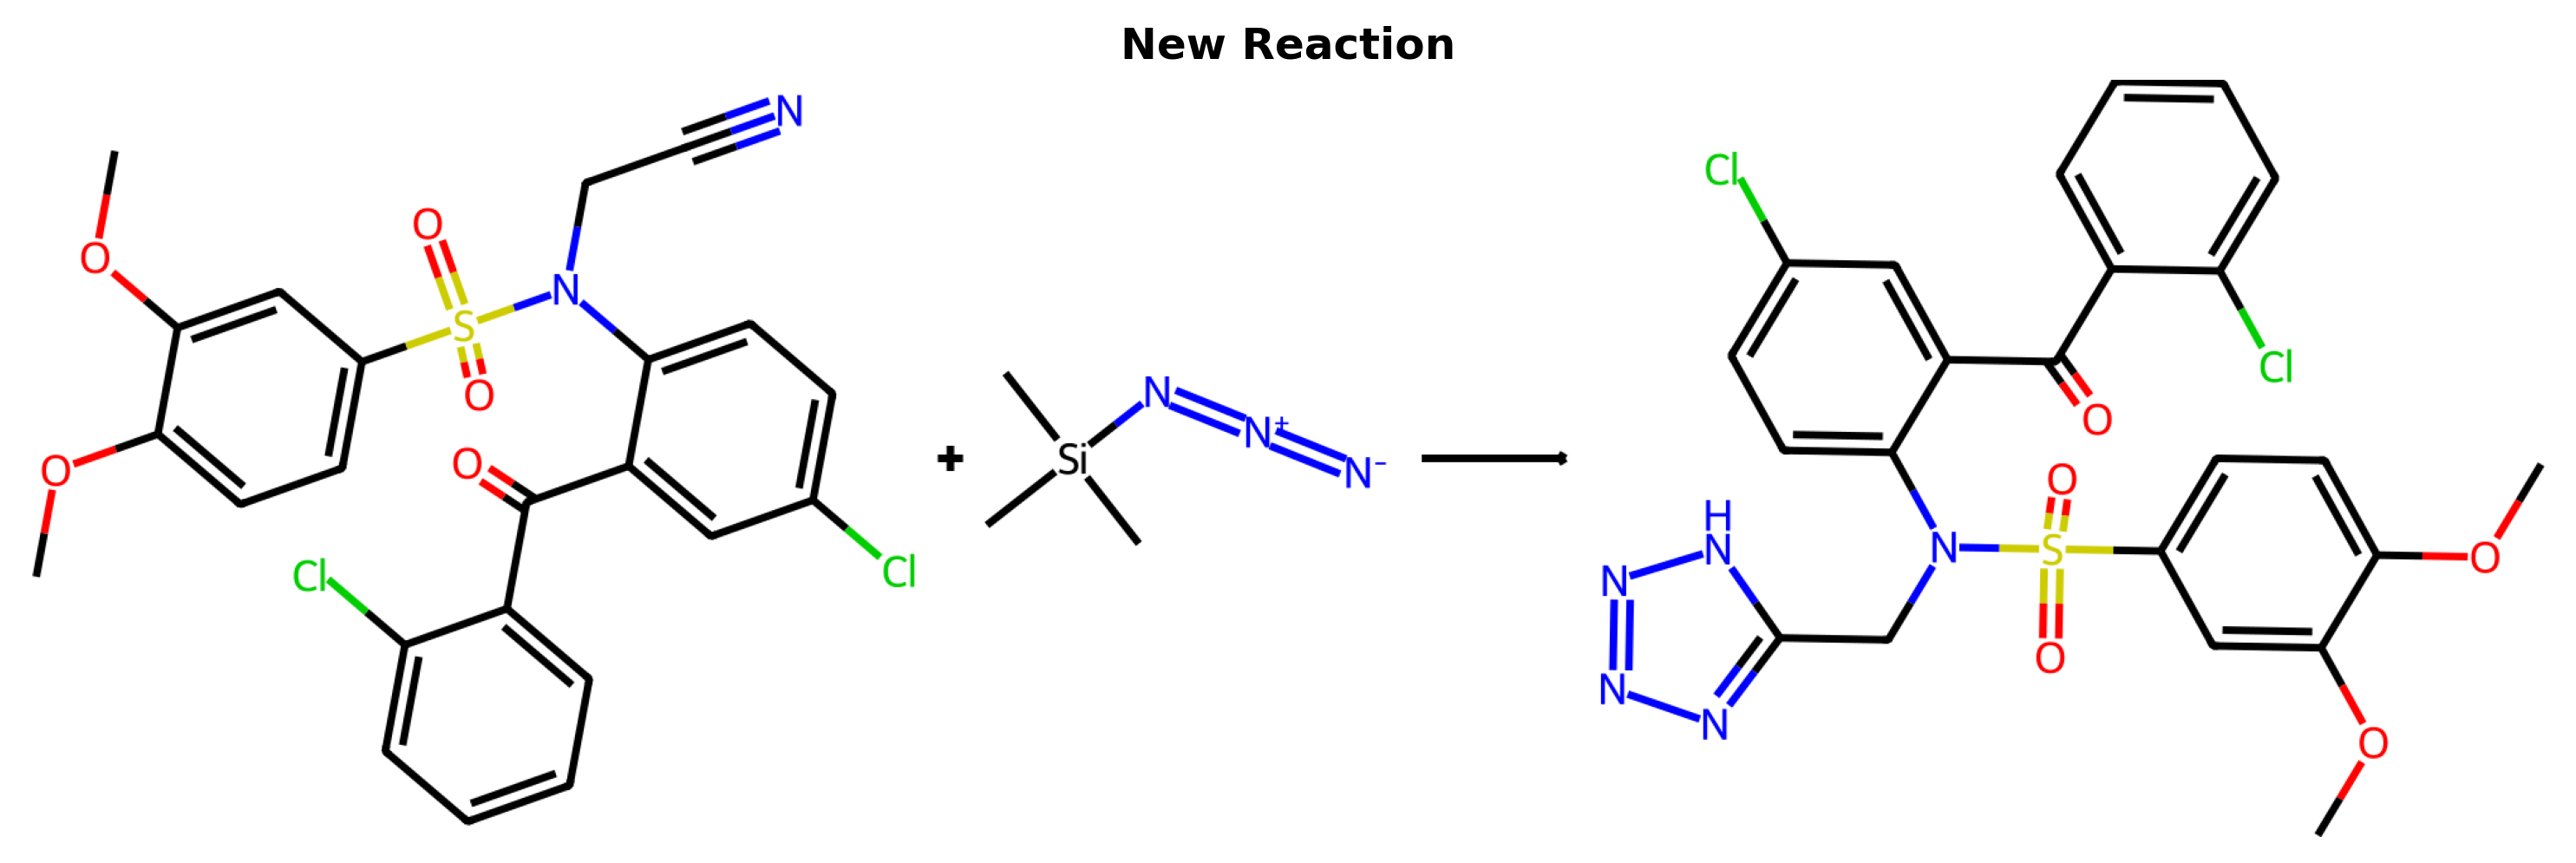

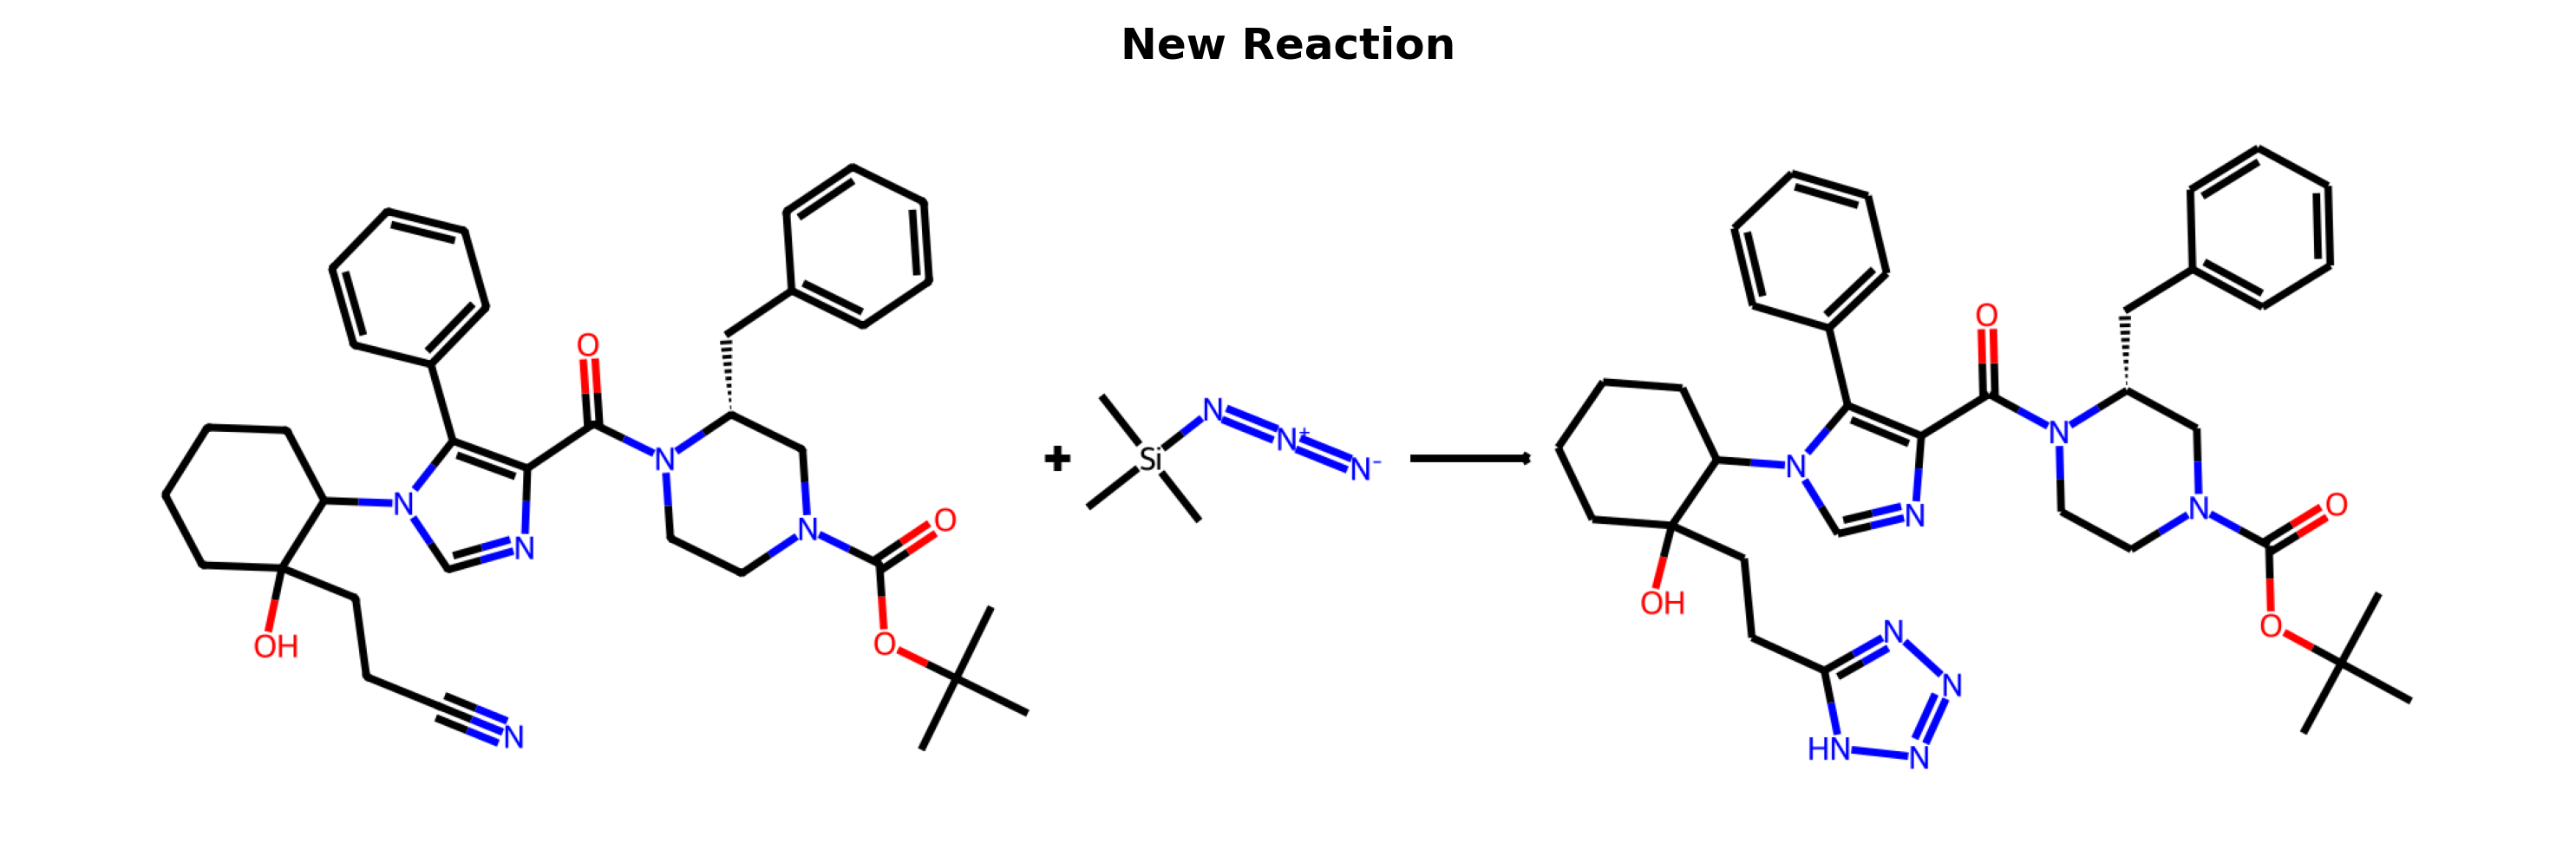

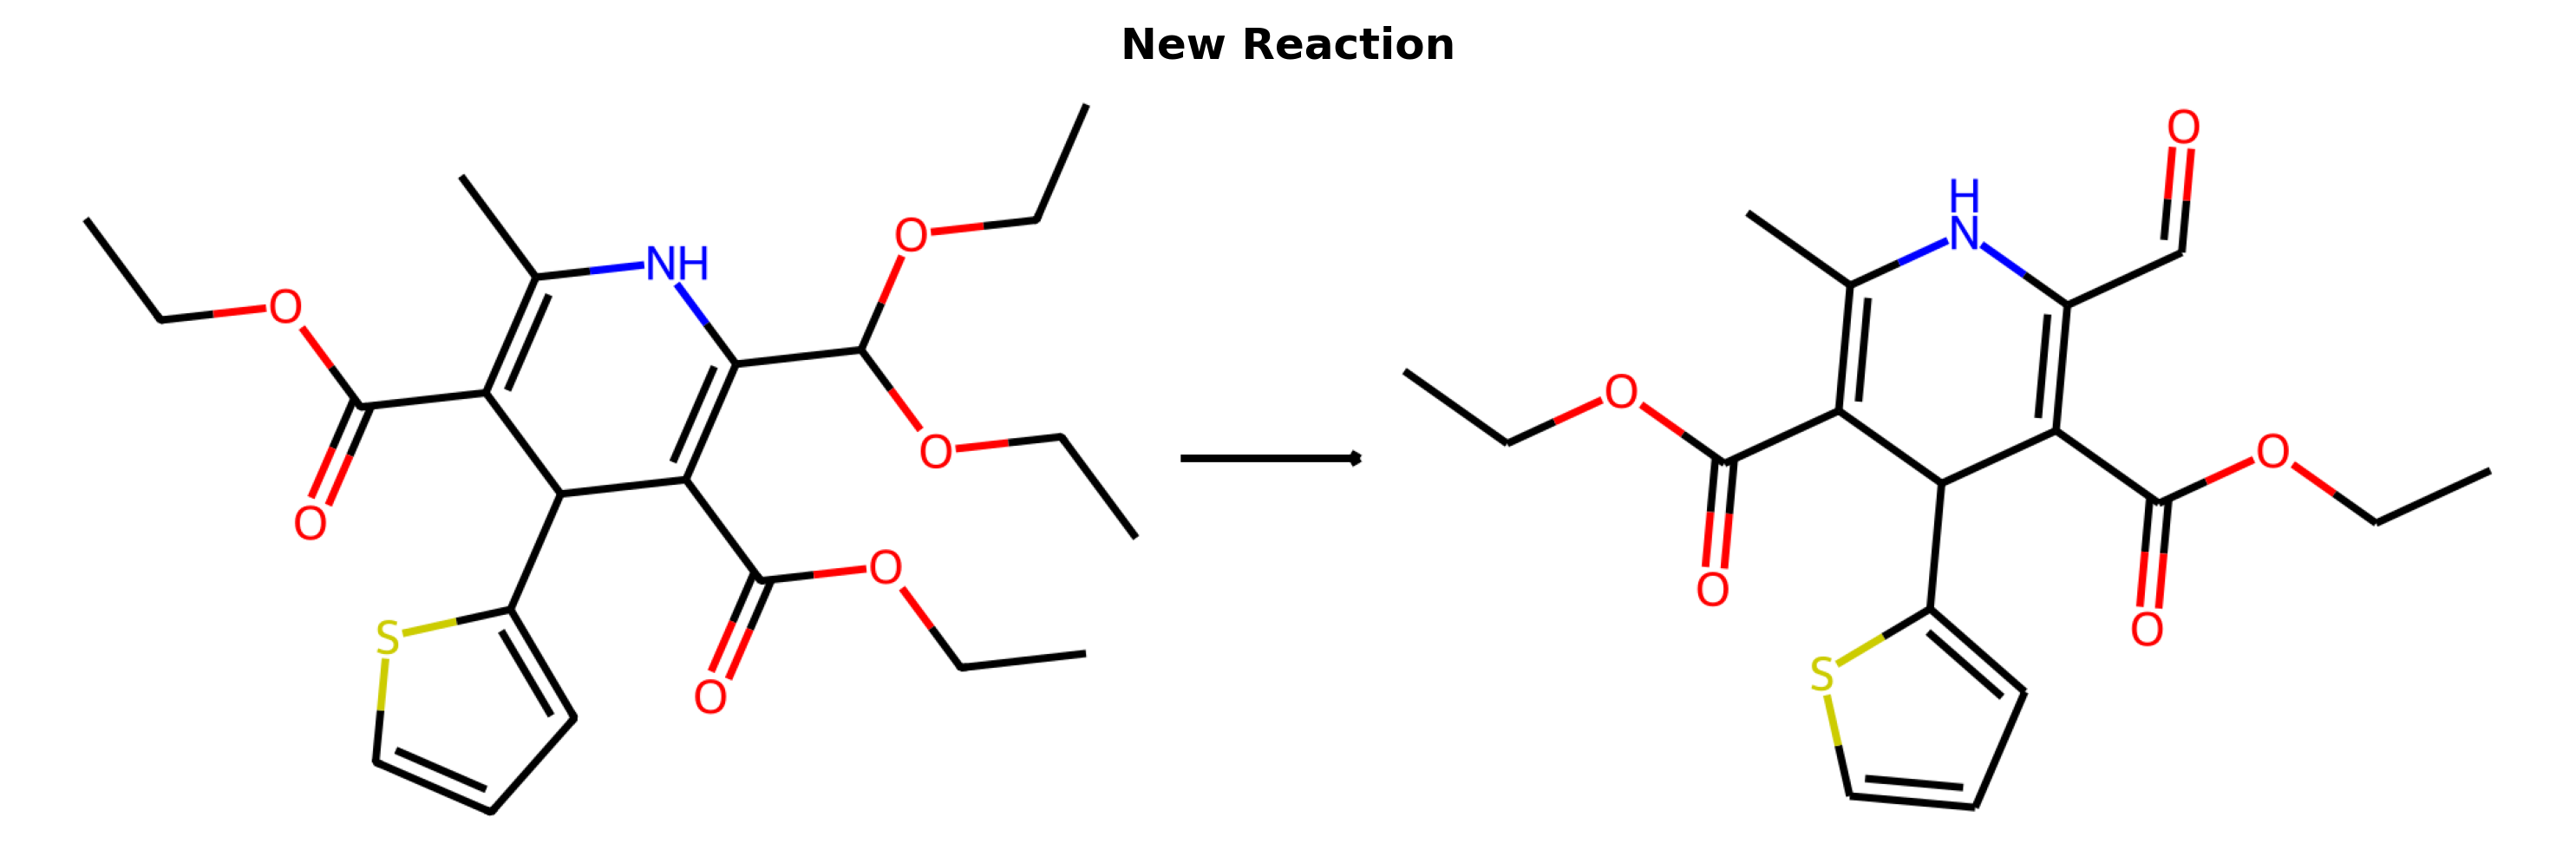

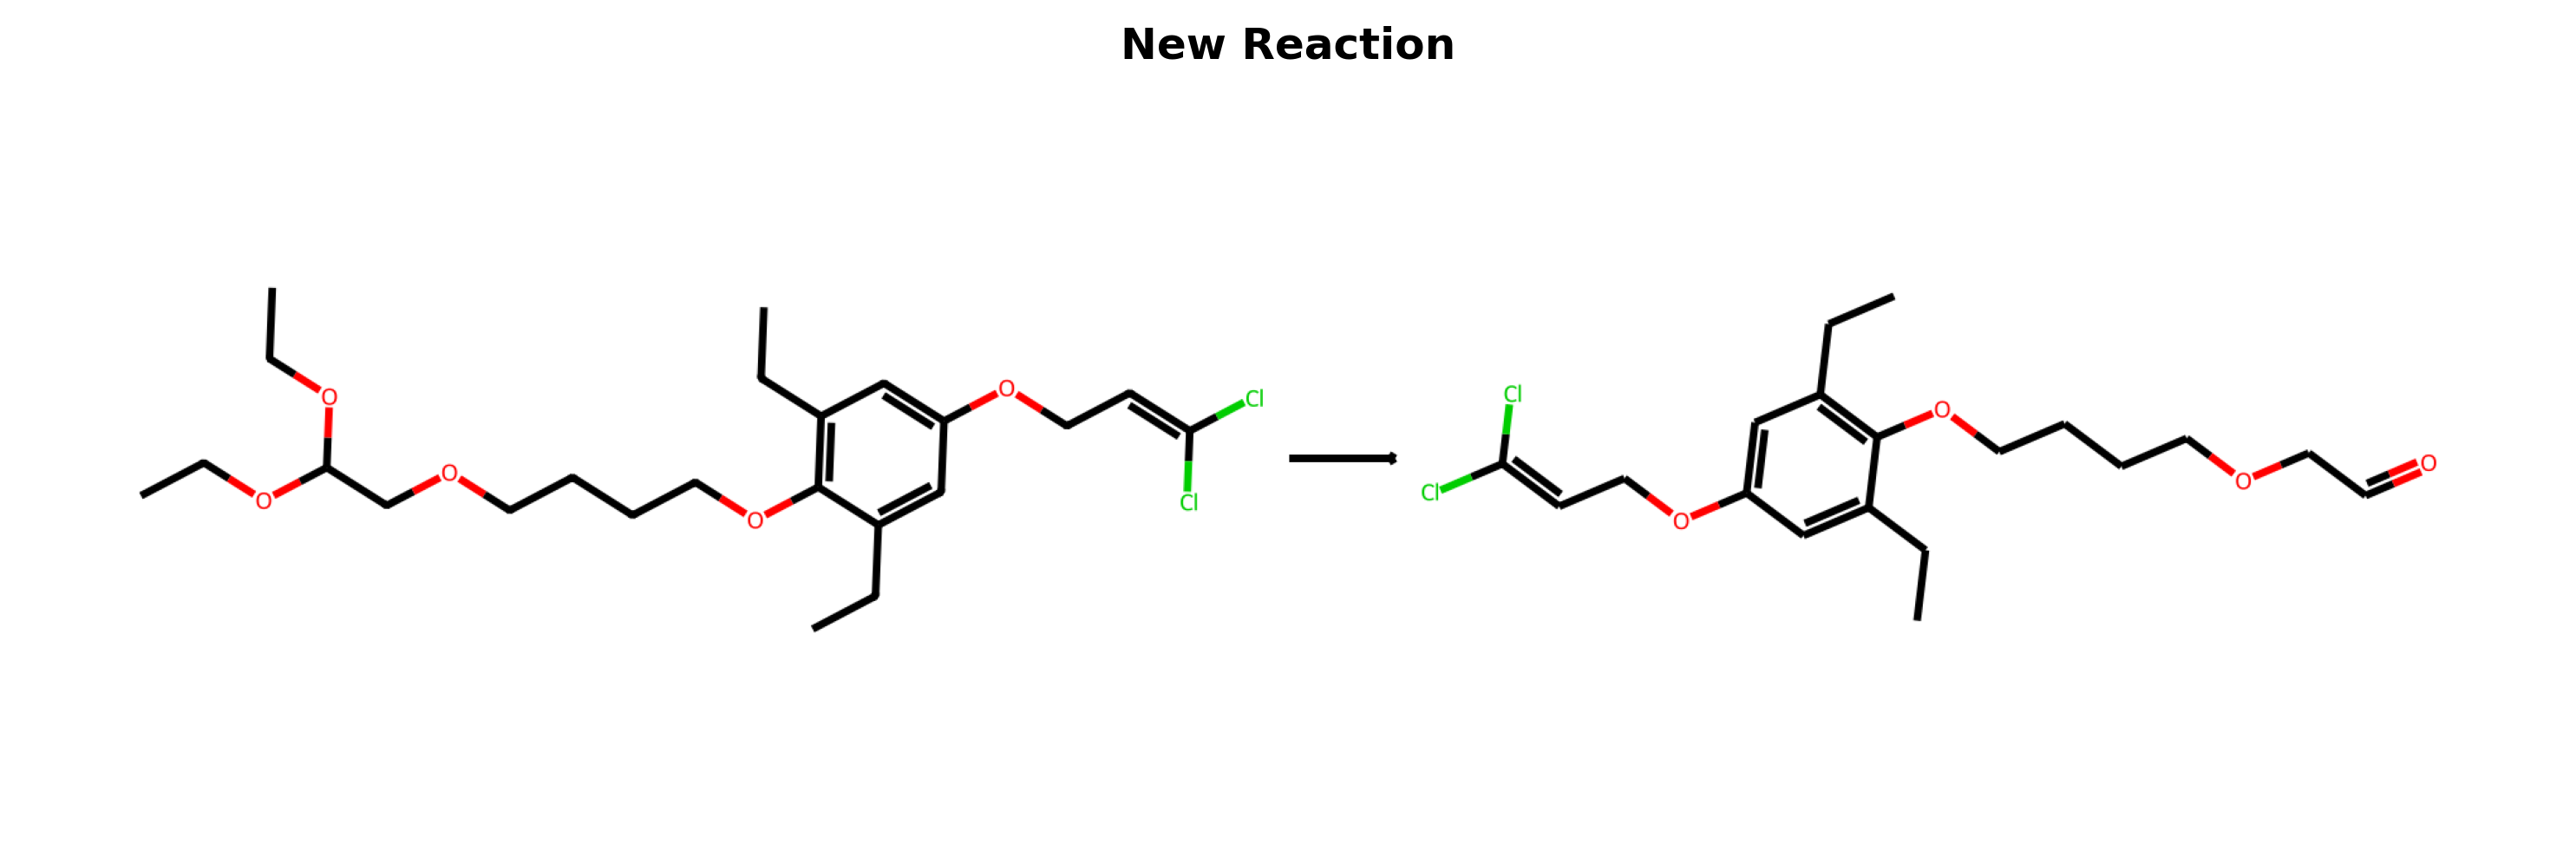

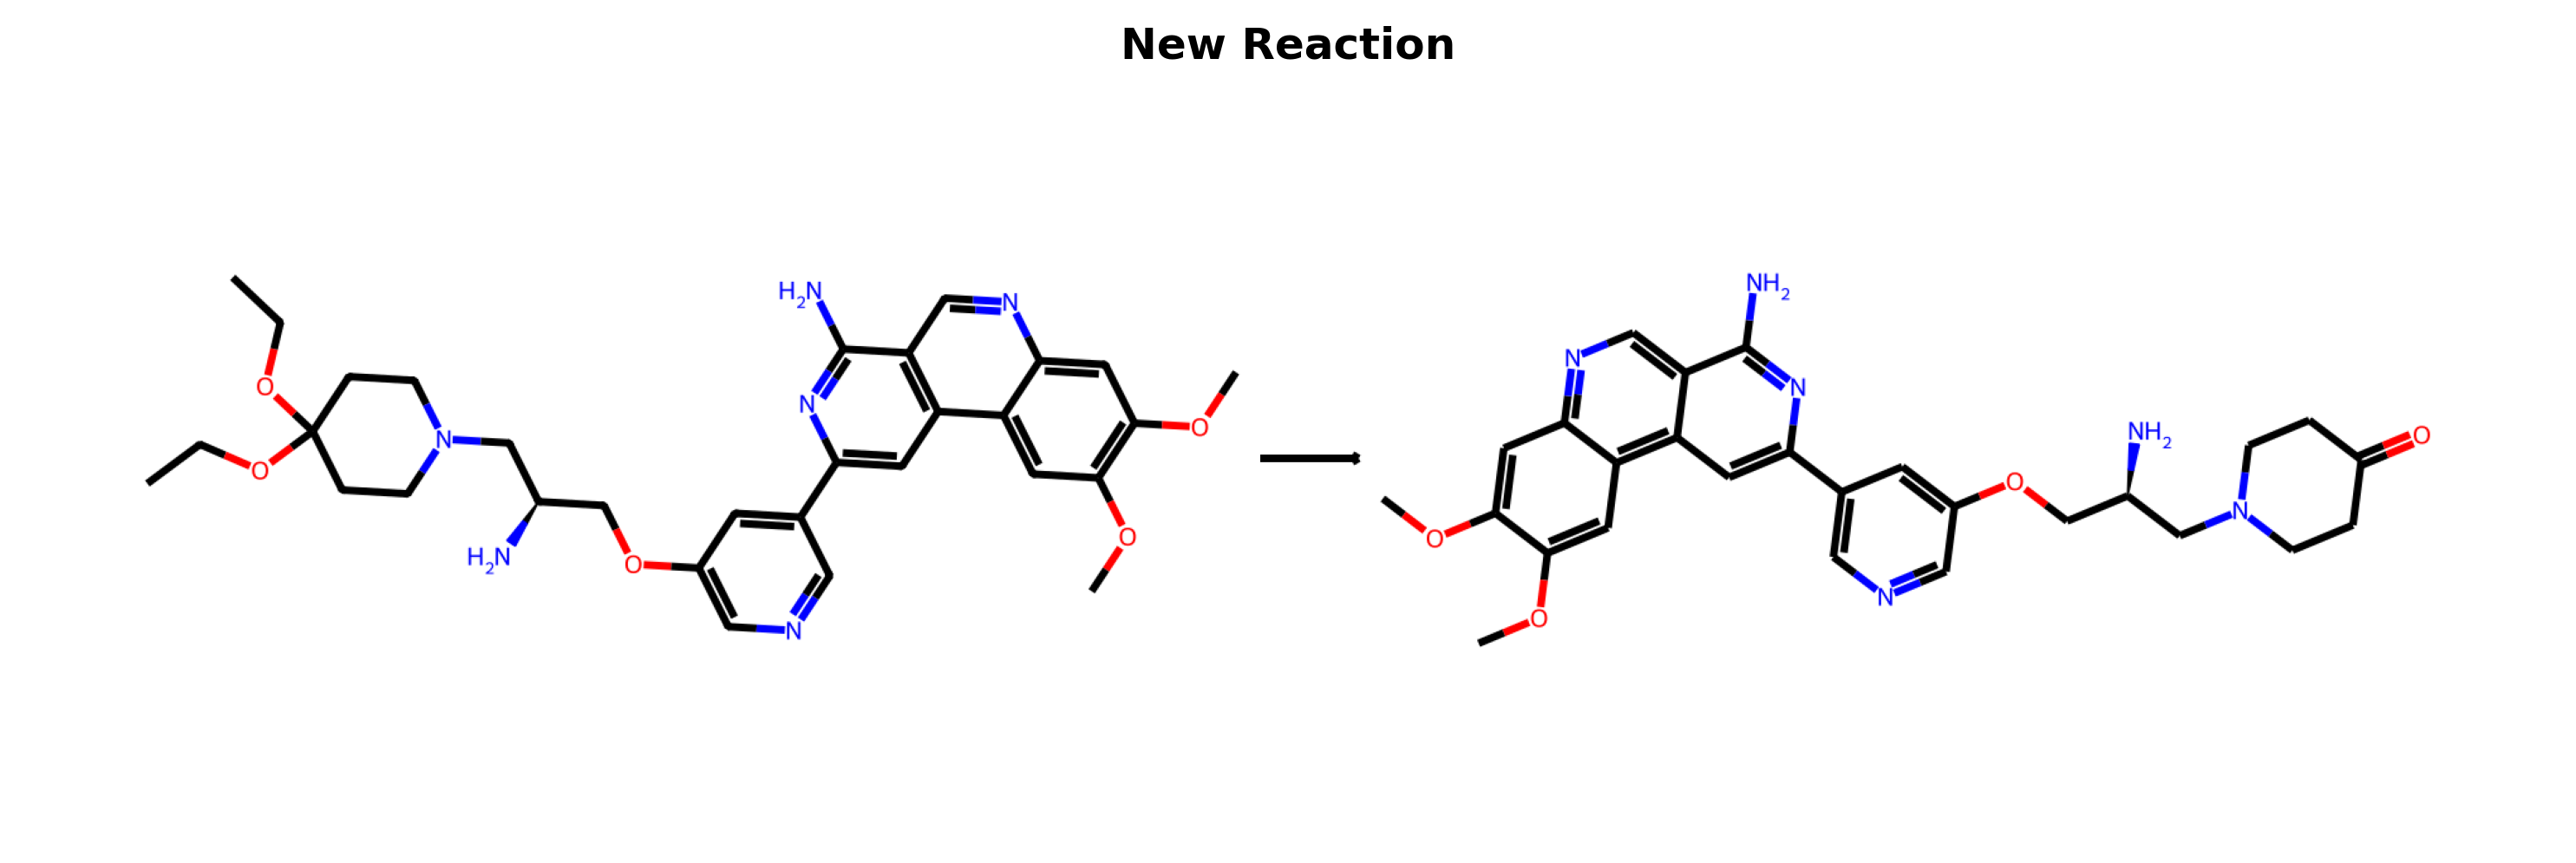

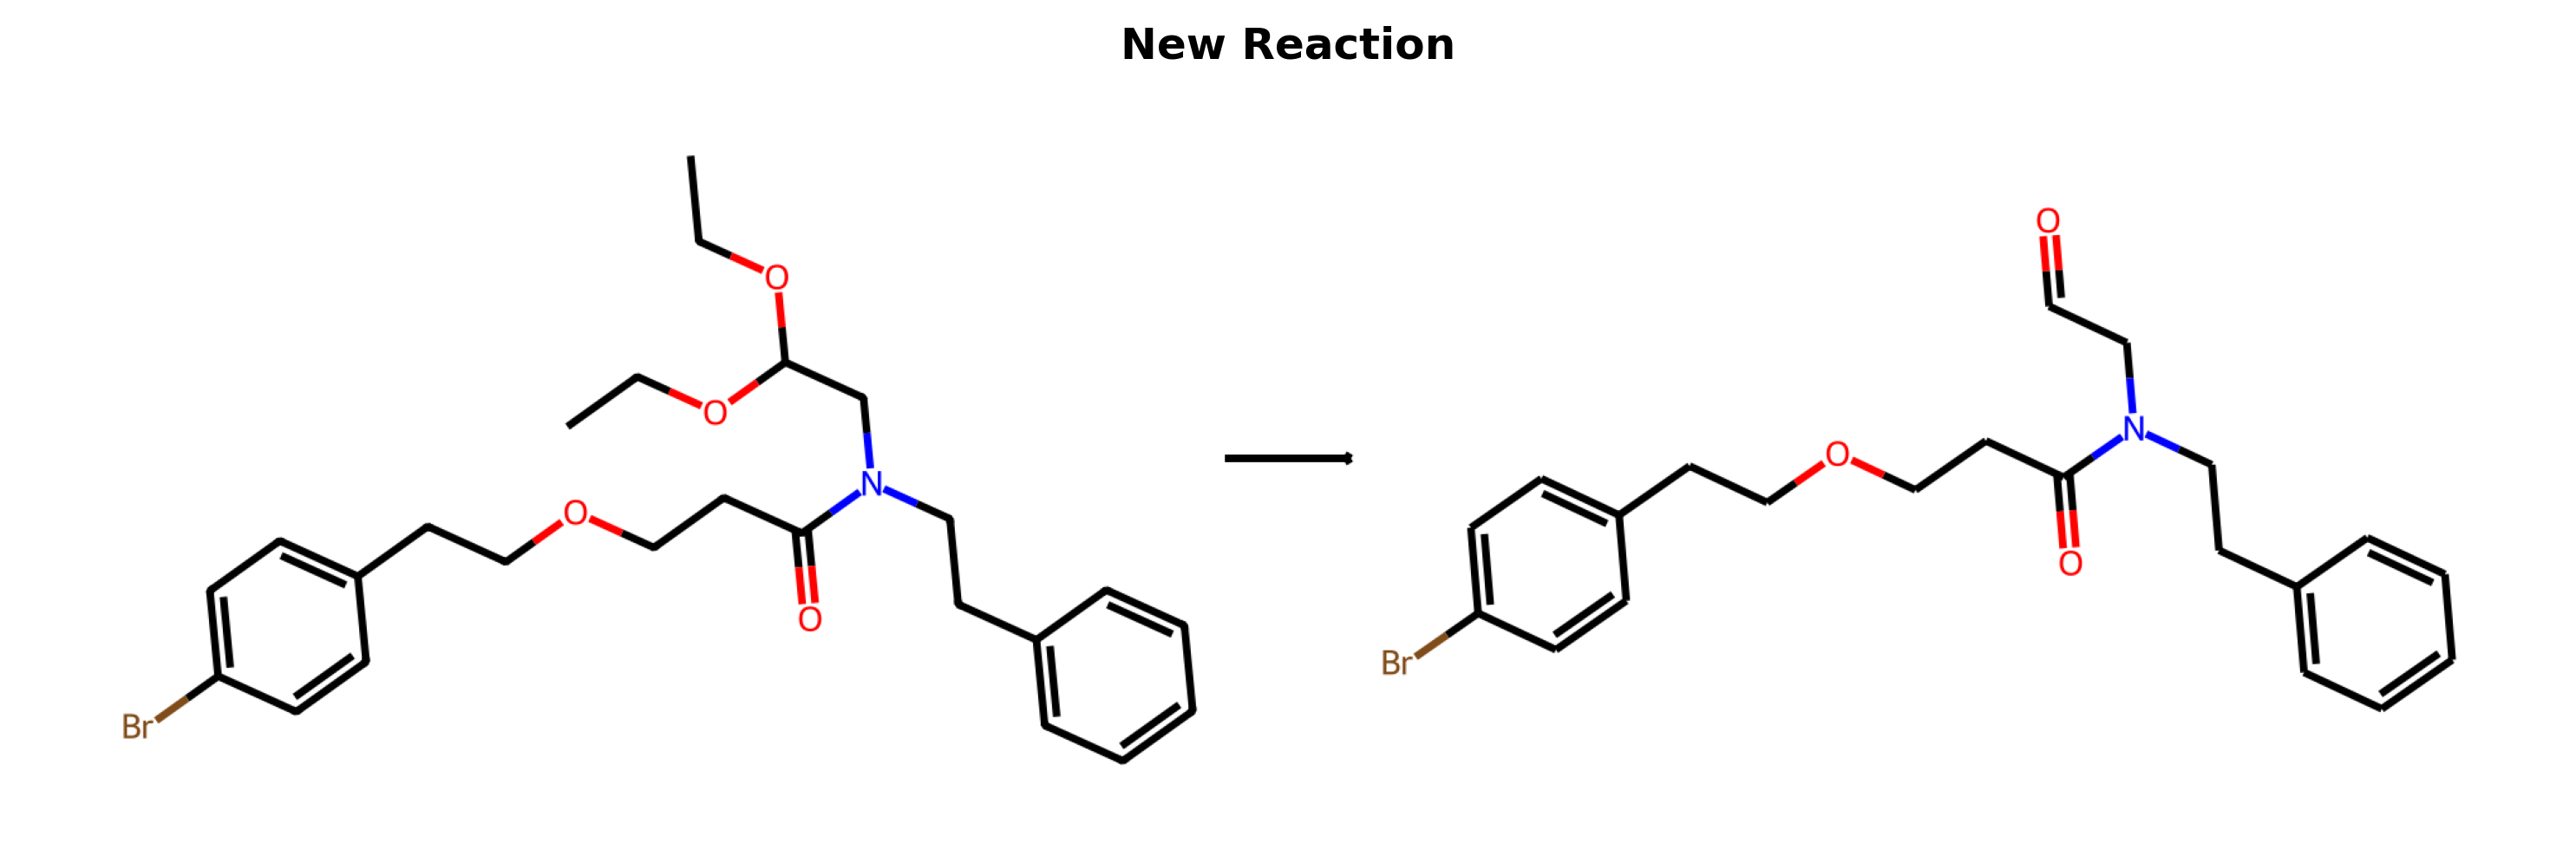

In [363]:
from  SynRBL.SynVis import ReactionVisualizer
vis = ReactionVisualizer()

for i in range(32, 40):
    try:
        vis = ReactionVisualizer()
        vis.plot_reactions(valid_mcs_uncertain[i], 'old_reaction', 'new_reaction', show_atom_numbers=False, compare= False, savefig=False, pathname = None, dpi=300)
    except:
        #print(i)
        vis.plot_reactions(valid_mcs_uncertain[i], 'reactions', 'reactions', show_atom_numbers=False, compare= False, savefig=False, pathname = None, dpi=300)



In [212]:
original_uncertainty[9]

{'id': 'US20130296569A1',
 'class': 4,
 'reactions': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1>>O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1',
 'reactants': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1',
 'products': 'O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1',
 'R-id': 'R1081',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 2, 'S': 1, 'O': 1, 'H': 7, 'Q': 1}}

In [399]:
valid_mcs_uncertain[32]

{'id': 'US05366987',
 'class': 4,
 'reactions': 'C#CCCCCCCCCCCCC.C[Si](C)(C)N=[N+]=[N-]>>CCCCCCCCCCCCc1c[nH]nn1',
 'reactants': 'C#CCCCCCCCCCCCC.C[Si](C)(C)N=[N+]=[N-]',
 'products': 'CCCCCCCCCCCCc1c[nH]nn1',
 'R-id': 'R21586',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 3, 'Si': 1, 'H': 8}}

In [440]:
def pseudo_mol(mol):
    """ Convert triple bonds to single bonds and remove aromaticity for MCS matching """
    edit_mol = Chem.RWMol(mol)
    Chem.Kekulize(edit_mol, clearAromaticFlags=True)
    for bond in edit_mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.TRIPLE:
            bond.SetBondType(Chem.BondType.DOUBLE)
    return edit_mol.GetMol()

def test_mcs(data_list, indice, addHs = False, trap_mol=False):
    reactant_mol = Chem.MolFromSmiles(data_list[indice]['reactants'])
    product_mol = Chem.MolFromSmiles(data_list[indice]['products'])

    params = rdFMCS.MCSParameters()
    #params.BondCompareParameters.RingMatchesRingOnly = True
    #params.BondCompareParameters.CompleteRingsOnly = False
    params.atomCompare = rdFMCS.AtomCompare.CompareAny
    params.bondCompare = rdFMCS.BondCompare.CompareAny  # If you want to ignore the bond order
    #params.matchValences = True
    mols = [reactant_mol, product_mol]
    if addHs == True:
        mols = [Chem.AddHs(mol) for mol in mols]
    if trap_mol == True:
        mols = [pseudo_mol(mol) for mol in mols]
    mcs = rdFMCS.FindMCS(mols, params)
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    return MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

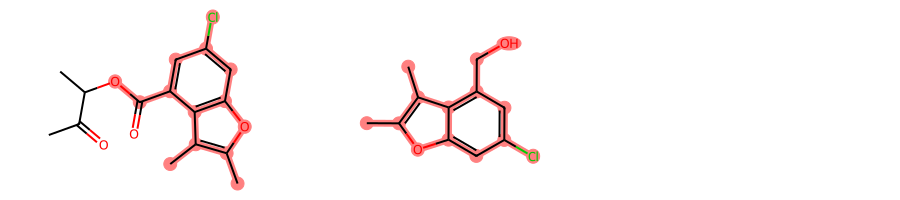

In [443]:
test_mcs(valid_mcs_uncertain, 41, addHs = False, trap_mol = False)

In [409]:
Chem.rdmolops.TrapPoints

AttributeError: module 'rdkit.Chem.rdmolops' has no attribute 'TrapPoints'

In [381]:
reactant_mol = Chem.MolFromSmiles(valid_mcs_uncertain[32]['reactants'])
product_mol = Chem.MolFromSmiles(valid_mcs_uncertain[32]['products'])

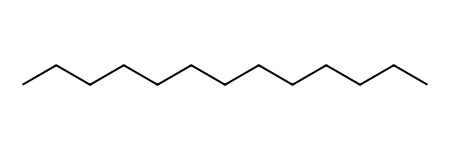

In [382]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
mcs = rdFMCS.FindMCS([reactant_mol, product_mol])
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
mcs_mol

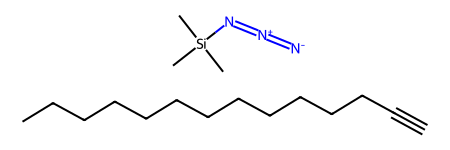

In [383]:
reactant_mol

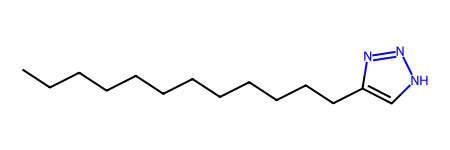

In [384]:
product_mol

In [385]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

In [386]:
class CompareOrderOutsideRings(rdFMCS.MCSBondCompare):
    def __call__(self, p, mol1, bond1, mol2, bond2):
        b1 = mol1.GetBondWithIdx(bond1)
        b2 = mol2.GetBondWithIdx(bond2)
        if (b1.IsInRing() and b2.IsInRing()) or (b1.GetBondType() == b2.GetBondType()):
            if (p.MatchStereo and not self.CheckBondStereo(p, mol1, bond1, mol2, bond2)):
                return False
            if p.RingMatchesRingOnly:
                return self.CheckBondRingMatch(p, mol1, bond1, mol2, bond2)
            return True
        return False
    
class CompareElementsOutsideRings(rdFMCS.MCSAtomCompare):
    def __call__(self, p, mol1, atom1, mol2, atom2):
        a1 = mol1.GetAtomWithIdx(atom1)
        a2 = mol2.GetAtomWithIdx(atom2)
        if (a1.GetAtomicNum() != a2.GetAtomicNum()) and not (a1.IsInRing() and a2.IsInRing()):
            return False
        if (p.MatchChiralTag and not self.CheckAtomChirality(p, mol1, atom1, mol2, atom2)):
            return False
        if p.RingMatchesRingOnly:
            return self.CheckAtomRingMatch(p, mol1, atom1, mol2, atom2)
        return True

In [387]:
mols = [reactant_mol, product_mol]

In [388]:
pseudo_mol = [preprocess_mol(mol) for mol in mols]

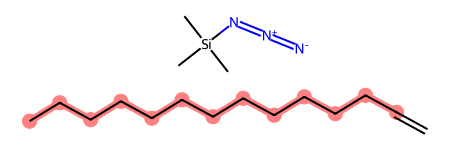

In [396]:
pseudo_mol[0]

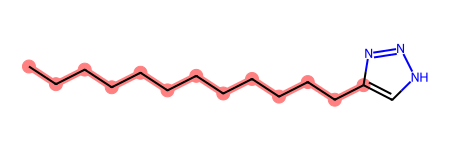

In [395]:
pseudo_mol[1]

In [348]:
mols_h = [Chem.AddHs(mol) for mol in mols]


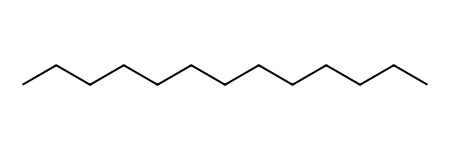

In [398]:
params = rdFMCS.MCSParameters()
#params.AtomTyper = CompareElementsOutsideRings()
#params.BondTyper = CompareOrderOutsideRings()
#params.BondCompareParameters.RingMatchesRingOnly = True
#params.BondCompareParameters.CompleteRingsOnly = False
#params.StoreAll = True
params.atomCompare = rdFMCS.AtomCompare.CompareAny
params.bondCompare = rdFMCS.BondCompare.CompareAny  # If you want to ignore the bond order
#params.matchValences = True
mcs = rdFMCS.FindMCS(pseudo_mol, params)
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
mcs_mol

In [377]:
mols

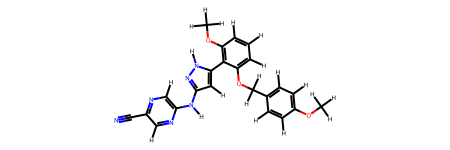

In [357]:
mols_h[0]

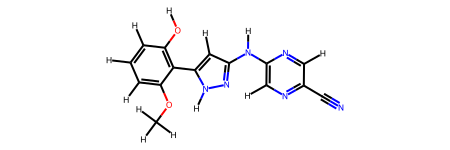

In [358]:
mols_h[1]

In [359]:
mcs.degenerateSmartsQueryMolDict.values()

dict_values([])

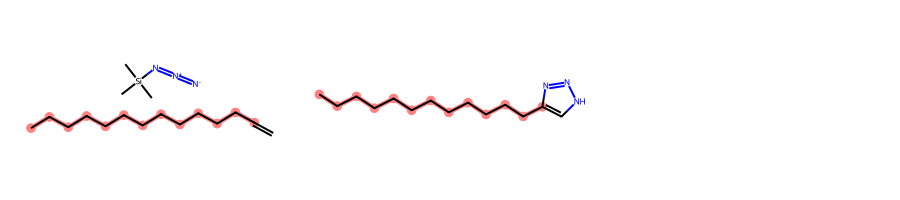

In [393]:
MolsToGridImage(pseudo_mol, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in pseudo_mol])

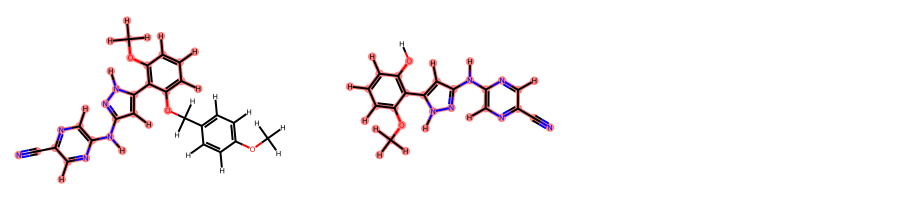

In [362]:
MolsToGridImage(mols_h, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols_h])

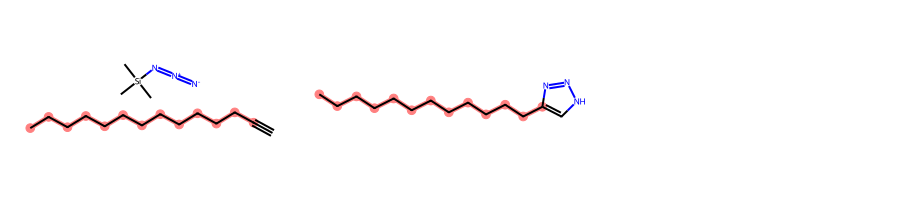

In [378]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

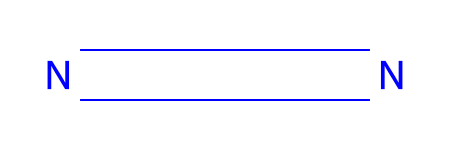

In [430]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

def trap_mol(mol):
    """ Convert triple bonds to single bonds and remove aromaticity for MCS matching """
    edit_mol = Chem.RWMol(mol)
    Chem.Kekulize(edit_mol, clearAromaticFlags=True)
    for bond in edit_mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.TRIPLE:
            bond.SetBondType(Chem.BondType.DOUBLE)
    return edit_mol.GetMol()

# Load your molecules
#mol1 = Chem.MolFromSmiles('C#CCCCCCCCCCCCC')
mol1 = Chem.MolFromSmiles('C[Si](C)(C)N=[N+]=[N-]')
mol2 = Chem.MolFromSmiles('CCCCCCCCCCCCc1c[nH]nn1')

# Preprocess the molecules
preprocessed_mols = [preprocess_mol(mol) for mol in [mol1, mol2]]

# Perform the MCS search
params = rdFMCS.MCSParameters()
params.atomCompare = rdFMCS.AtomCompare.CompareAny
params.bondCompare = rdFMCS.BondCompare.CompareAny
params.atomCompare = rdFMCS.AtomCompare.CompareElements
params.ignoreIonization = True                          # Ignore charges

mcs_result = rdFMCS.FindMCS(preprocessed_mols, params)

mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)

# Print the SMARTS string of the MCS
Chem.MolFromSmarts(mcs_result.smartsString)


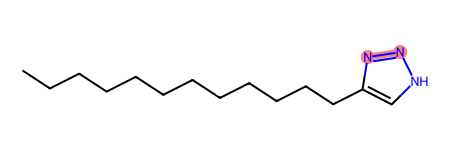

In [427]:
preprocessed_mols[1]

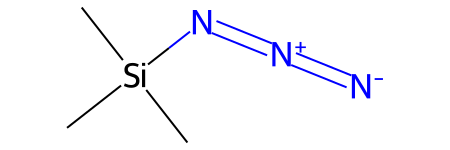

In [424]:
mol1

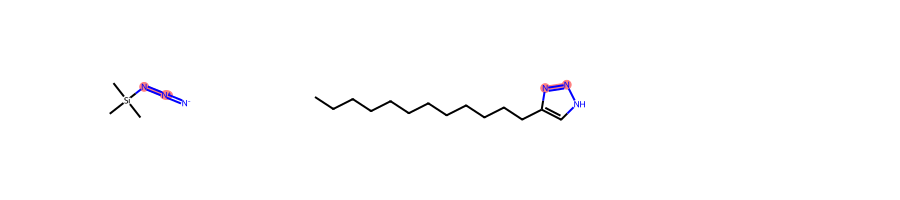

In [425]:
MolsToGridImage(preprocessed_mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs_result.queryMol) for m in preprocessed_mols])